In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# from gensim.models import Word2Vec
# from gensim.models import KeyedVectors
import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [4]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


Dropping cols

In [5]:
data = data[(data['subtask_b'] == 'TIN') | (data['subtask_b'] == 'UNT')]
data.drop(columns  = ['subtask_a' , 'subtask_c'] , inplace  = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_b,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,UNT,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,TIN,11,6
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,UNT,11,6
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,TIN,6,2
6,77444,@USER @USER Oh noes! Tough shit.,oh noes tough shit,2,0,0,0,UNT,6,4


# Splitting Data: Train and Test


In [6]:
Y = data['subtask_b']
X = data.drop(['subtask_b','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (4400, 8)
Shape of Y:  (4400,)


In [7]:
data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

#### Observation:   
We see that the dataset is clearly imbalanced with Targeted Insulting tweets being the majority class.


In [8]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y,random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (3080, 8)
Shape of Y_train:  (3080,)
Shape of X_test:  (1320, 8)
Shape of Y_test:  (1320,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(TIN=0, UNT=1))
Y_test = Y_test.map(dict(TIN=0, UNT=1))

# Making Data Model Ready: Encoding Tweets

## 1. Bag of Words : Tweets


In [10]:
vectorizer_tweet_bow = CountVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_bow.fit(X_train['new_tweet'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
X_train_tweet_bow = vectorizer_tweet_bow.transform(X_train['new_tweet'])
X_test_tweet_bow = vectorizer_tweet_bow.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_bow ",X_train_tweet_bow.shape)
print("Shape of X_test_tweet_bow ",X_test_tweet_bow.shape)

Shape of X_train_tweet_bow  (3080, 1771)
Shape of X_test_tweet_bow  (1320, 1771)


##2. TF-IDF : Tweets

In [12]:
vectorizer_tweet_tfidf = TfidfVectorizer(min_df=5,ngram_range=(1,2))
vectorizer_tweet_tfidf.fit(X_train['new_tweet'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [13]:
X_train_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_train['new_tweet'])
X_test_tweet_tfidf = vectorizer_tweet_tfidf.transform(X_test['new_tweet'])

print("Shape of X_train_tweet_tfidf ",X_train_tweet_tfidf.shape)
print("Shape of X_test_tweet_tfidf ",X_test_tweet_tfidf.shape)

Shape of X_train_tweet_tfidf  (3080, 1771)
Shape of X_test_tweet_tfidf  (1320, 1771)


##3. Avg W2Vec : Tweets

In [0]:
# average Word2Vec
from scipy.sparse import csr_matrix  ## to make data type consistency across all methods


def get_avg_w2v(corpus):
    with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    avg_w2v_vectors=[]
    for sentence in tqdm(corpus): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)
    return csr_matrix(avg_w2v_vectors)

In [15]:
X_train_tweet_avg_w2v_vectors = get_avg_w2v(X_train['new_tweet'])
X_test_tweet_avg_w2v_vectors = get_avg_w2v(X_test['new_tweet'])

100%|██████████| 1320/1320 [00:00<00:00, 26236.01it/s]


In [16]:
# print("Shape of X_train_tweet_avg_w2v_vectors",len(X_train_tweet_avg_w2v_vectors),len(X_train_tweet_avg_w2v_vectors[0]))
# print("Shape of X_test_tweet_avg_w2v_vectors ",len(X_test_tweet_avg_w2v_vectors),len(X_test_tweet_avg_w2v_vectors[0]))
print("Shape of X_train_tweet_avg_w2v_vectors",X_train_tweet_avg_w2v_vectors.shape )
print("Shape of X_test_tweet_avg_w2v_vectors ",X_test_tweet_avg_w2v_vectors.shape )

Shape of X_train_tweet_avg_w2v_vectors (3080, 300)
Shape of X_test_tweet_avg_w2v_vectors  (1320, 300)


# Applying Naive Bayes on different featurization of Tweets

## 1. BOW



In [17]:
f1 = X_train_tweet_bow
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
# X_train_bow_naive =hstack((f1,f2,f3,f4))

X_train_bow_naive =hstack((f1,f2,f3,f4,f5))
X_train_bow_naive.shape

(3080, 1775)

In [18]:
f1 = X_test_tweet_bow
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
# X_test_bow_naive =hstack((f1,f2,f3,f4))

# print(type(f1))
X_test_bow_naive =hstack((f1,f2,f3,f4,f5))
X_test_bow_naive.shape

(1320, 1775)

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1163
           1       0.30      0.11      0.16       157

    accuracy                           0.86      1320
   macro avg       0.59      0.54      0.54      1320
weighted avg       0.82      0.86      0.83      1320



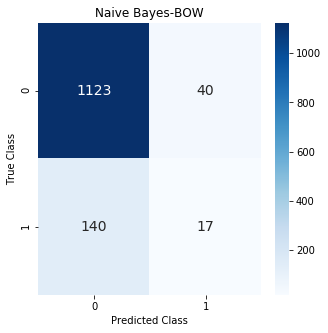

In [19]:
naive_bow = MultinomialNB()
naive_bow.fit(X_train_bow_naive.todense(),Y_train)

y_test_predict = naive_bow.predict(X_test_bow_naive.todense())
results = confusion_matrix(Y_test, y_test_predict)
print(classification_report(Y_test, y_test_predict))
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Naive Bayes-BOW')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [20]:
print(y_test_predict)

[0 0 0 ... 0 0 0]


In [21]:
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average= 'macro') ))

F1 Score = 0.5423411484617577


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
def print_stuff(idx):
  global y_test_pred # probabilities
  global X_test
  global y_test #original class
  global y_test_predict #predicted class
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('class predicted: ',y_test_predict[idx])
  print('original class: ',y_test[idx])

In [24]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

180 misclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [26]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER I love that feeling that u get from going from Blues to purples. The discovery of new sexy loot!
preprocessed tweet
i love feel u get go blue purple discovery new sexy loot
class predicted:  0
original class:  1
 @USER IM SAVING THIS GOOD SHITTTT
preprocessed tweet
im save good shitttt
class predicted:  0
original class:  1
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to fend for its self for 13 days before help arrived.  Trump is a FAKE PRESIDENT"
preprocessed tweet
funny top things you try show you its white republicans path storm entire island leave fend its self 13 days help arrive trump fake president
class predicted:  0
original class:  1
 @USER UK Govt non announcements are the only consistant and affordable policy under Labour or Conservatives for decades. Designed for a soundbite. No immediate resource required. Never likely to ever be implemented. Its propogan

## 2. TF-IDF


In [27]:
f1 = X_train_tweet_tfidf
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
# X_train_tfidf =hstack((f1,f2,f3,f4))

# print(type(f1))
X_train_tfidf =hstack((f1,f2,f3,f4,f5))
X_train_tfidf.shape

(3080, 1775)

In [28]:
f1 = X_test_tweet_tfidf
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
# X_test_tfidf =hstack((f1,f2,f3,f4))

X_test_tfidf =hstack((f1,f2,f3,f4,f5))
X_test_tfidf.shape

(1320, 1775)

### Confusion Matrix

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1163
           1       0.29      0.30      0.29       157

    accuracy                           0.83      1320
   macro avg       0.60      0.60      0.60      1320
weighted avg       0.83      0.83      0.83      1320



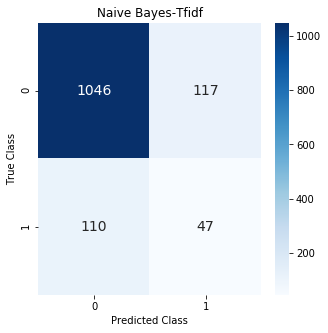

In [31]:
naive_tfidf = MultinomialNB(fit_prior = False)
naive_tfidf.fit(X_train_tfidf.todense(),Y_train)

y_test_predict = naive_tfidf.predict(X_test_tfidf.todense())
print(classification_report(Y_test, y_test_predict))
results = confusion_matrix(Y_test, y_test_predict)
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Naive Bayes-Tfidf')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [32]:
print("F1 Score = " + str(f1_score(Y_test,y_test_predict,average='macro')))

F1 Score = 0.5974739353491877


### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

227 misclassifications


Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER Everyone in Washington including John Heinz is being uncovered as the corrupt elites they are...Like cockroaches running from the light.
preprocessed tweet
everyone washington include john heinz uncover corrupt elites they be like cockroaches run light
class predicted:  1
original class:  0
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
preprocessed tweet
behold conservatives deliberately ignore fact ok gesture use benign co opt racists signal they re white supremacy much like swastikas benign asian countries amp still be co opt amp ruin nazis
class predicted:  1
original class:  0
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to

## 3. AvgW2Vec 

In [0]:
f1 = X_train_tweet_avg_w2v_vectors
f2 = X_train['user_mentions'].values.reshape(-1,1)
f3 = X_train['n_hash_tags'].values.reshape(-1,1)
f4 = X_train['n_urls'].values.reshape(-1,1)
f5 = X_train['n_emojis'].values.reshape(-1,1)
# X_train_w2vec =hstack((f1,f2,f3,f4))

X_train_w2vec =hstack((f1,f2,f3,f4,f5))
X_train_w2vec.shape

(3080, 304)

In [0]:
f1 = X_test_tweet_avg_w2v_vectors
f2 = X_test['user_mentions'].values.reshape(-1,1)
f3 = X_test['n_hash_tags'].values.reshape(-1,1)
f4 = X_test['n_urls'].values.reshape(-1,1)
f5 = X_test['n_emojis'].values.reshape(-1,1)
# X_test_w2vec =hstack((f1,f2,f3,f4))

X_test_w2vec =hstack((f1,f2,f3,f4,f5))
X_test_w2vec.shape

(1320, 304)

### Misclassified examples

In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_test_predict)

In [0]:
# print(type(misclassified))
print(len(misclassified[0]), 'misclassifications')

227 misclassifications


In [0]:
# print(X_test.iloc[0,0])

Red: original Targeted insult (0), classified as untargeted (1) <br>
Green: original untargeted (1), classified as Targeted insult (0)

In [0]:
#TIN=0, UNT=1
for index in misclassified[0]:
  #original Targeted insult (0), classified as untargeted (1)
  if y_test[index] == 0 and y_test_predict[index] == 1:
    prRed(X_test.iloc[index,0])
  #original untargeted (1), classified as Targeted insult (0)
  elif y_test[index] == 1 and y_test_predict[index] == 0:
    prGreen(X_test.iloc[index,0])

KeyboardInterrupt: ignored

##Query 

In [0]:
query_tweet = %sx read -p ""


In [0]:
print(query_tweet)

['@User Donald Trump has gone mad again']


In [0]:
tweet_text = remove_user(query_tweet[0])
tweet_text = perform_cleaning(tweet_text)
tweet_text = do_tokenize_lemmatize(tweet_text)

number_hashtags = get_hash_tags(query_tweet[0]) 
number_users = get_user_mentions(query_tweet[0])
number_url = get_url_count(query_tweet[0])
number_emoji = get_emoji_count(query_tweet[0])

In [0]:
print(tweet_text)

user donald trump go mad


In [0]:
sample_bow = vectorizer_tweet_bow.transform([tweet_text])

In [0]:
f1 = sample_bow
f2 = number_users
f3 = number_hashtags
f4 = number_url
f5 = number_emoji
test_bow_naive =hstack((f1,f2,f3,f4,f5))

In [0]:
y_test_predict = naive_bow.predict(test_bow_naive)

In [0]:
print(y_test_predict) # 0-targeted  1-untargeted

[0]


In [0]:
# Example tried for untargeted "Oh Shit here we go again" which accurately classifies as untargetted